# Libraries

In [1]:
import pandas as pd
import re
import itertools
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np

#Spark
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark import SparkConf

# Spark ML
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.feature import HashingTF, Tokenizer, StopWordsRemover
from pyspark.ml.classification import DecisionTreeClassifier, GBTClassifier, LogisticRegression
from pyspark.ml.regression import DecisionTreeRegressor, GBTRegressor, DecisionTreeRegressionModel



#Spark SQL functions
from pyspark.sql.functions import *
from pyspark.sql.functions import from_utc_timestamp, udf, array_distinct, col, when
from pyspark.sql.functions import regexp_replace, year, month, dayofmonth, hour, format_string
from pyspark.sql.functions import monotonically_increasing_id

# Spark Datatypes
from pyspark.sql.types import StringType, TimestampType, DateType, IntegerType
from pyspark.sql.types import DoubleType, StructType, FloatType, StructField

# Spark evaluation metrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


#Sentiment Analyzer
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#Hadoop
from hdfs import InsecureClient

## Warnings conf

In this sections the warnings are suppressed, less logs while running the code

In [2]:
import warnings

# Suppressing the warnings
warnings.filterwarnings('ignore') 

# Data Loading

## Reading Data from Hadoop

In this section we are reading data from Hadoop, using a Spark Session.

### Spark configurations and Connection

In [3]:
def spark_start(restart = False, appname="HadoopAccess"):

    if restart == True:
        spark.stop()
    
    # Configuration parameters for Spark
    spark_conf = SparkConf().setMaster("local[*]").setAppName(appname)

    # Using SparkSession
    spark = SparkSession.builder.config(conf=spark_conf).config('spark.sql.session.timeZone', 'UTC').getOrCreate()
    
    return spark


spark = spark_start()

 # this will help not to have too much error displaying
sc = spark.sparkContext
sc.setLogLevel('ERROR')


2023-05-31 00:41:19,842 WARN util.Utils: Your hostname, BDS-2023 resolves to a loopback address: 127.0.1.1; using 192.168.0.110 instead (on interface wlo1)
2023-05-31 00:41:19,843 WARN util.Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2023-05-31 00:41:20,451 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
2023-05-31 00:41:21,374 WARN util.Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


# Creating Models in Spark

In [4]:
#Reading all parquets file in the folder tweets on Hadoop
tweets_pred_saved = spark.read.parquet("/CA4/sentiment/**/*.parquet")

## Binary Sentiment

### creating a binary sentiment

The binary sentiment is being created using the score to define whether it is negative(0) or positive(1).

In [5]:
#getting sentiment
tweets_fc = tweets_pred_saved.withColumn('sentiment',when(col("score") > 0, '1').otherwise('0'))

A dataframe segmented by year, month, day, hour and sentiment was created, using score columns for average and a count of the amount of Tweets.

# Tweets by hour

In [6]:
spark.conf.set("spark.sql.legacy.timeParserPolicy","LEGACY")

tweets_hour = tweets_fc.groupBy(year("created_at").alias("year"), 
                              month("created_at").alias("month"),
                              dayofmonth("created_at").alias("day"),
                              hour("created_at").alias("hour"),
                              "sentiment") \
                        .agg(mean(col("score")).alias("hourly_score"), count(col("score")).alias("hourly_count")) \
                        .orderBy(["year", "month", "day", "hour"])

In [7]:
tweets_hour = tweets_hour.withColumn("datetime", to_timestamp(concat_ws("-", col("year"), col("month"), col("day"), col("hour")), "yyyy-MM-dd-HH"))

## Exploration

In [8]:
tweets_hour.printSchema()

root
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- sentiment: string (nullable = false)
 |-- hourly_score: double (nullable = true)
 |-- hourly_count: long (nullable = false)
 |-- datetime: timestamp (nullable = true)



In [9]:
tweets_hour.show(10)

+----+-----+---+----+---------+--------------------+------------+-------------------+
|year|month|day|hour|sentiment|        hourly_score|hourly_count|           datetime|
+----+-----+---+----+---------+--------------------+------------+-------------------+
|2021|   11|  1|   0|        0|-0.11364917380729236|          97|2021-11-01 00:00:00|
|2021|   11|  1|   0|        1|   0.216212583461736|          59|2021-11-01 00:00:00|
|2021|   11|  1|   1|        0|-0.12294147748246585|          86|2021-11-01 01:00:00|
|2021|   11|  1|   1|        1|  0.1684199659639877|          69|2021-11-01 01:00:00|
|2021|   11|  1|   2|        1| 0.19855952781193165|          65|2021-11-01 02:00:00|
|2021|   11|  1|   2|        0|-0.09541717757936509|          80|2021-11-01 02:00:00|
|2021|   11|  1|   3|        1| 0.22375465097402597|          60|2021-11-01 03:00:00|
|2021|   11|  1|   3|        0|-0.11240666473937021|          73|2021-11-01 03:00:00|
|2021|   11|  1|   4|        0|-0.14758262344999634|  

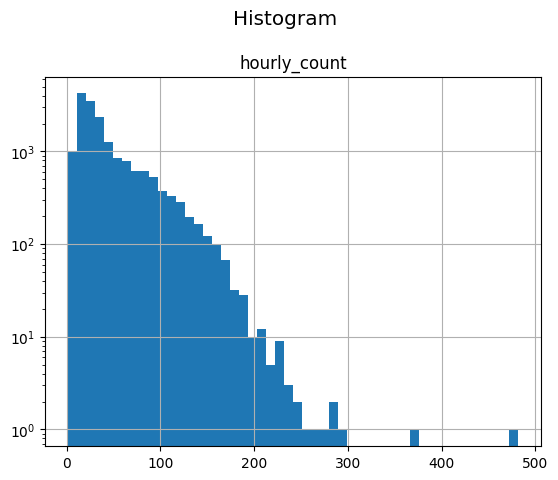

In [10]:
plot_df = tweets_hour.select('hourly_count').toPandas()

plot_df.hist(bins = 50)
plt.yscale('log')
plt.suptitle('Histogram',x=0.5, y=1.02, fontsize='x-large');

In the graph above it is possible to verify that there is no normal distribution of the data.

## Transformation

#### Functions

In [11]:
def convert_type(df,to_string=[], to_integer=[], to_double = []):
    col_names = df.columns
    
    if len(to_string) > 0:
        for col in to_string:
            df = df.withColumn(col,df[col].cast(StringType()))
    
    if len(to_integer) > 0:
        for col in to_integer:
            df = df.withColumn(col,df[col].cast(IntegerType()))
            
    if len(to_double) > 0:
        for col in to_double:
            df = df.withColumn(col,df[col].cast(DoubleType()))
            
    return df

In [12]:
def compute_metrics_reg(predictions, model_name, labelcol = 'target'):
    
    rmse_obj = RegressionEvaluator(metricName = 'rmse', predictionCol = 'prediction', labelCol = labelcol)
    
    rsquared_obj = RegressionEvaluator(metricName = 'r2', predictionCol = 'prediction', labelCol = labelcol)
    
    print(model_name, 'Metrics:\nRMSE Score:',\
          str(rmse_obj.evaluate(predictions))+ '\nR-Squared Value:',\
          str(rsquared_obj.evaluate(predictions)))

## AutoARIMA

### Getting features

In [13]:
from statsforecast.distributed.utils import forecast
from statsforecast.distributed.fugue import FugueBackend
from statsforecast.models import AutoARIMA
from statsforecast.core import StatsForecast


In [14]:
df_hour = tweets_hour.select('sentiment', 'datetime', 'hourly_count') \
                        .withColumnRenamed('sentiment', 'unique_id') \
                        .withColumnRenamed('datetime', 'ds') \
                        .withColumnRenamed('hourly_count', 'y')
df_hour.printSchema()

root
 |-- unique_id: string (nullable = false)
 |-- ds: timestamp (nullable = true)
 |-- y: long (nullable = false)



### Dataframes - Training and Testing 

In [15]:
hour_test_df = df_hour.filter((to_date(date_format('ds', 'yyyy-MM-dd')) >= '2022-10-01') & 
                               (to_date(date_format('ds', 'yyyy-MM-dd')) <= '2022-10-30')
                              )

hour_train_df = df_hour.filter((to_date(date_format('ds', 'yyyy-MM-dd')) < '2022-10-01'))

print ("Training:", hour_train_df.count(), 
       f"-> {(hour_train_df.count()/df_hour.count()*100):.2f}%")

print("Testing:", hour_test_df.count(),
      f"-> {(hour_test_df.count()/df_hour.count()*100):.2f}%\n")


# Caching the dataframe
hour_train_df = hour_train_df.drop('month')
hour_test_df = hour_test_df.drop('month')


# Caching the dataframe
hour_train_df.cache()
hour_test_df.cache()


# Schema
hour_train_df.printSchema()
hour_test_df.printSchema()

Training: 16016 -> 91.50%


Testing: 1440 -> 8.23%

root
 |-- unique_id: string (nullable = false)
 |-- ds: timestamp (nullable = true)
 |-- y: long (nullable = false)

root
 |-- unique_id: string (nullable = false)
 |-- ds: timestamp (nullable = true)
 |-- y: long (nullable = false)



### Testing Model

In [ ]:
n_test = int((hour_test_df.count())/2)

backend = FugueBackend(spark, {"fugue.spark.use_pandas_udf":True})

pred_hour = forecast(hour_train_df, 
                     [AutoARIMA(season_length = 24)], 
                     freq = "H", 
                     h = n_test,
                     level = [90],
                     parallel=backend)

pred_hour.printSchema()
pred_hour.count()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def forecast_kpi(true_col, pred_col):
    mae = mean_absolute_error(true_col, pred_col)
    mse = mean_squared_error(true_col, pred_col)
    mape = np.mean(np.abs((true_col - pred_col) / true_col)) * 100
    rsme = np.sqrt(np.mean((true_col - pred_col) ** 2))

    print(f"MAPE: {mape:.4f}")
    print(f"RSME: {rsme:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")    

In [ ]:
forecast_kpi(true_col = hour_test_df.select("y").toPandas()["y"], 
             pred_col = pred_hour.select("AutoARIMA").toPandas()["AutoARIMA"])

### **Conclusion**

Based on the indicators presented, we can state the following about the model, with a confidence level of 90:

The MAE (Mean Absolute Error) is 17.7570, which means that, on average, the model predictions have an absolute error of about 17.75 units with respect to the actual values.

The MSE (Mean Squared Error) is 628.78, which means that the model has a relatively high variance from the actual values.

The MAPE (Mean Absolute Percent Error) is 55.32%, which means that, on average, the model predictions have an absolute percent error of about 55.32% with respect to the actual values.

The RMSE (Root Mean Squared Error) is 25.07, which means that, on average, the model predictions have an absolute error of about 25.07 units relative to the actual values.

Based on these indicators, we can say that the model may not be performing well, as it has a high average error and a high average absolute percentage error.

## Classification Models

### Getting features

In [16]:
tweets_hour_cts_reg = tweets_hour.drop('hourly_score', 'datetime').withColumnRenamed('hourly_count', 'target')
tweets_hour_cts_reg.printSchema()

hour_cts_reg_str = ['year', 'month', 'day', 'hour', 'sentiment']
hour_cts_reg_int = ['target']

tweets_hour_cts_reg = convert_type(df = tweets_hour_cts_reg,
                                  to_string = hour_cts_reg_str, 
                                  to_integer = hour_cts_reg_int)
tweets_hour_cts_reg.printSchema()

root
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- sentiment: string (nullable = false)
 |-- target: long (nullable = false)

root
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day: string (nullable = true)
 |-- hour: string (nullable = true)
 |-- sentiment: string (nullable = false)
 |-- target: integer (nullable = false)



### Pipeline

#### Stage 1: Create Pipeline Stages

In [17]:
#Stage 1 
#String Indexer
inputCols = hour_cts_reg_str
outputCols = [f'{x}_str_dex' for x in hour_cts_reg_str]

hour_cts_reg_stage_1 = StringIndexer(inputCols=inputCols, 
                                     outputCols=outputCols, 
                                     handleInvalid='keep')

#Stage 2
#One Hot Encoder
inputCols_OHE = [x for x in outputCols] 
outputCols_OHE = [f'{x}_ohe' for x in inputCols]

hour_cts_reg_stage_2 = OneHotEncoder(inputCols=inputCols_OHE, 
                                     outputCols=outputCols_OHE)

#Stage 3
#Assembler
inputCols_reg = hour_cts_reg_int
inputCols_reg.extend(outputCols_OHE)

hour_cts_reg_stage_3 = VectorAssembler(inputCols=inputCols_reg,
                                        outputCol="features")

#### Stage 2: Building Models

##### Stage 2.1: Decision Tree classification

In [18]:
hour_cts_reg_dt_stage_4 = DecisionTreeRegressor(featuresCol = 'features', labelCol = 'target',impurity='variance',\
                                       maxDepth=5, maxBins=40) 


In [19]:
hour_cts_reg_dt_pipeline = Pipeline(stages = [hour_cts_reg_stage_1,
                                    hour_cts_reg_stage_2,
                                    hour_cts_reg_stage_3,
                                    hour_cts_reg_dt_stage_4])

##### Stage 2.2: GB Tree classification

In [20]:
hour_cts_reg_gbt_stage_4 = GBTRegressor(featuresCol="features",labelCol = 'target', maxIter=5)

In [21]:
hour_cts_reg_gbt_pipeline = Pipeline(stages = [hour_cts_reg_stage_1,
                                    hour_cts_reg_stage_2,
                                    hour_cts_reg_stage_3,
                                    hour_cts_reg_gbt_stage_4])

### Dataframes - Training and Testing 

In [22]:
hour_cts_reg_train_df = tweets_hour_cts_reg.filter((tweets_hour_cts_reg.month != 10))

hour_cts_reg_test_df = tweets_hour_cts_reg.filter((tweets_hour_cts_reg.month == 10))

print ("Training:", hour_cts_reg_train_df.count(), 
       f"-> {(hour_cts_reg_train_df.count()/tweets_hour_cts_reg.count()*100):.2f}%")

print("Testing:", hour_cts_reg_test_df.count(),
      f"-> {(hour_cts_reg_test_df.count()/tweets_hour_cts_reg.count()*100):.2f}%\n")


# Caching the dataframe
hour_cts_reg_train_df.cache()
hour_cts_reg_test_df.cache()


# Schema
hour_cts_reg_train_df.printSchema()
hour_cts_reg_test_df.printSchema()

Training: 16016 -> 91.50%
Testing: 1488 -> 8.50%

root
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day: string (nullable = true)
 |-- hour: string (nullable = true)
 |-- sentiment: string (nullable = false)
 |-- target: integer (nullable = false)

root
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day: string (nullable = true)
 |-- hour: string (nullable = true)
 |-- sentiment: string (nullable = false)
 |-- target: integer (nullable = false)



### Training and evaluating models

#### **Decision Tree**

In [31]:
# pipeline
hour_cts_reg_dt_model = hour_cts_reg_dt_pipeline.fit(hour_cts_reg_train_df)

# make predictions
hour_cts_reg_dt_Predictions = hour_cts_reg_dt_model.transform(hour_cts_reg_test_df)

In [32]:
hour_cts_reg_dt_Predictions.select('year', 'month', 'day', 'hour', 'target', 'prediction').show(5)

+----+-----+---+----+------+------------------+
|year|month|day|hour|target|        prediction|
+----+-----+---+----+------+------------------+
|2022|   10|  1|   0|     9|10.392089423903696|
|2022|   10|  1|   0|    20|              21.0|
|2022|   10|  1|   1|    13|14.548862115127175|
|2022|   10|  1|   1|    17|18.029345372460497|
|2022|   10|  1|   2|    28| 28.48132427843803|
+----+-----+---+----+------+------------------+
only showing top 5 rows



In [33]:
compute_metrics_reg(hour_cts_reg_dt_Predictions,'Decision Tree Model', labelcol = 'target')

Decision Tree Model Metrics:
RMSE Score: 1.2257165552628206
R-Squared Value: 0.9959086296912545


#### **GB Tree**

In [34]:
# pipeline
hour_cts_reg_gbt_model = hour_cts_reg_gbt_pipeline.fit(hour_cts_reg_train_df)

# make predictions
hour_cts_reg_gbt_Predictions = hour_cts_reg_gbt_model.transform(hour_cts_reg_test_df)

In [35]:
hour_cts_reg_gbt_Predictions.select('year', 'month', 'day', 'hour', 'target', 'prediction').show(5)

+----+-----+---+----+------+------------------+
|year|month|day|hour|target|        prediction|
+----+-----+---+----+------+------------------+
|2022|   10|  1|   0|     9|10.027619741854085|
|2022|   10|  1|   0|    20|  21.0106871573056|
|2022|   10|  1|   1|    13|13.633128580970368|
|2022|   10|  1|   1|    17|18.040032529766098|
|2022|   10|  1|   2|    28| 28.49201143574363|
+----+-----+---+----+------+------------------+
only showing top 5 rows



In [36]:
compute_metrics_reg(hour_cts_reg_gbt_Predictions, 'GB Tree Model', labelcol = 'target')

GB Tree Model Metrics:
RMSE Score: 1.3614825894613858
R-Squared Value: 0.9949520752854163


#### **Conclusion**

Both Regression models proved to be effective.
The Decision Tree model proved to be slightly better at predicting values more accurately, as it has a slightly lower RMSE and also has a greater ability to explain data variability, since its R-Squared value is a little higher.
In this way, the Decision Tree Model will be used to predict the data.

#### Saving Model

In [37]:
try:
    hour_cts_reg_dt_model.stages[-1].save('/CA4/forecast/models/DT_Regression_count_by_sentiment_per_hour_noLag')
    hour_cts_reg_gbt_model.stages[-1].save('/CA4/forecast/models/GBT_Regression_count_by_sentiment_per_hour_noLag')
except:
    print('Already Saved')

Already Saved


I tried to use the created model to predict using Spark, however I couldn't execute the ".predict( df )" command for the classification models and AutoArima hasn't got a good performance. Because the short time frame to research and solve the problems found, I abandoned the forecast using Spark and passed the dataframe to pandas, since the dataframe was now not so big and could be used with pandas. Anyway, the models have been saved in Hadoop and can be used in the future.

# Creating Models in Pandas

In [4]:
#Reading all parquets file in the folder tweets on Hadoop
tweets_hour = spark.read.parquet("/CA4/forecast/dataframe/*.parquet")

In [5]:
#getting the dataframe
tweets_hour.printSchema()

root
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- sentiment: string (nullable = true)
 |-- hourly_score: double (nullable = true)
 |-- hourly_count: long (nullable = true)
 |-- datetime: timestamp (nullable = true)



In [6]:
#converting to pandas
tweets_hour_pd = tweets_hour.withColumn("datetime", date_format("datetime", "yyyy-MM-dd HH:mm:ss")).toPandas()
tweets_hour_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17504 entries, 0 to 17503
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          17504 non-null  int32  
 1   month         17504 non-null  int32  
 2   day           17504 non-null  int32  
 3   hour          17504 non-null  int32  
 4   sentiment     17504 non-null  object 
 5   hourly_score  17504 non-null  float64
 6   hourly_count  17504 non-null  int64  
 7   datetime      17504 non-null  object 
dtypes: float64(1), int32(4), int64(1), object(2)
memory usage: 820.6+ KB


## Dropping Duplicate

pySpark is creating the time 2022-10-30 01:00:00 repeated, this is causing a problem with the timeseries functions. In this way, 2 lines will be removed. I couldn't identify the reason.

In [7]:
print(len(tweets_hour_pd))
tweets_hour_pd[tweets_hour_pd.datetime == '2022-10-30 01:00:00']


17504


,year,month,day,hour,sentiment,hourly_score,hourly_count,datetime
17410,2022,10,30,1,1,0.187613,30,2022-10-30 01:00:00
17411,2022,10,30,1,0,-0.169047,30,2022-10-30 01:00:00


In [8]:
tweets_hour_pd= tweets_hour_pd.drop_duplicates(subset=['datetime','sentiment'])
print(len(tweets_hour_pd))
tweets_hour_pd[tweets_hour_pd.datetime == '2022-10-30 01:00:00']

17504


,year,month,day,hour,sentiment,hourly_score,hourly_count,datetime
17410,2022,10,30,1,1,0.187613,30,2022-10-30 01:00:00
17411,2022,10,30,1,0,-0.169047,30,2022-10-30 01:00:00


## EDA

In [9]:
# multiprocessing
from joblib import Parallel, delayed

# data manipulation
import numpy as np
import pandas as pd
from darts import TimeSeries
from darts.utils.timeseries_generation import datetime_attribute_timeseries

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# transformers and preprocessing
from darts.dataprocessing.transformers import Scaler

# models
#from darts.models import NaiveSeasonal, StatsForecastAutoARIMA, ExponentialSmoothing, Prophet #local
#from darts.models import LightGBMModel, RNNModel, NBEATSModel, TFTModel #global

# likelihood
from darts.utils.likelihood_models import GaussianLikelihood

# evaluation
from darts.metrics import mape, coefficient_of_variation, mae 

# settings
import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

### Trend and seasonality

In [10]:
# make copy of df
dataset_scaled_EDA = tweets_hour_pd.copy()

# min max value calculation
dataset_scaled_EDA['min_hour'] = dataset_scaled_EDA.groupby(['hour','sentiment'])[['hourly_count']] \
                                    .transform(lambda x: x.min())
dataset_scaled_EDA['max_hour'] = dataset_scaled_EDA.groupby(['hour','sentiment'])[['hourly_count']] \
                                    .transform(lambda x: x.max())

# scale
dataset_scaled_EDA['hour_scaled'] = (dataset_scaled_EDA['hourly_count'] - dataset_scaled_EDA['min_hour'])/(dataset_scaled_EDA['max_hour'] - dataset_scaled_EDA['min_hour'])

# add info about year, week of year and day of week
dataset_scaled_EDA['datetime'] = pd.to_datetime(dataset_scaled_EDA['datetime'])
dataset_scaled_EDA['day_of_week'] = [d.strftime('%A') for d in dataset_scaled_EDA['datetime']]
dataset_scaled_EDA['day_of_week'] = pd.Categorical(dataset_scaled_EDA['day_of_week'], 
  categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], 
  ordered=True)

dataset_scaled_EDA.head(10) 

,year,month,day,hour,sentiment,hourly_score,hourly_count,datetime,min_hour,max_hour,hour_scaled,day_of_week
0,2021,11,1,0,0,-0.113649,97,2021-11-01 00:00:00,3,226,0.421525,Monday
1,2021,11,1,0,1,0.216213,59,2021-11-01 00:00:00,1,164,0.355828,Monday
2,2021,11,1,1,0,-0.122941,86,2021-11-01 01:00:00,5,238,0.347639,Monday
3,2021,11,1,1,1,0.168420,69,2021-11-01 01:00:00,5,173,0.380952,Monday
4,2021,11,1,2,1,0.198560,65,2021-11-01 02:00:00,4,155,0.403974,Monday
5,2021,11,1,2,0,-0.095417,80,2021-11-01 02:00:00,2,175,0.450867,Monday
6,2021,11,1,3,0,-0.112407,73,2021-11-01 03:00:00,6,216,0.319048,Monday
7,2021,11,1,3,1,0.223755,60,2021-11-01 03:00:00,4,137,0.421053,Monday
8,2021,11,1,4,0,-0.147583,59,2021-11-01 04:00:00,4,171,0.329341,Monday
9,2021,11,1,4,1,0.214048,46,2021-11-01 04:00:00,2,136,0.328358,Monday


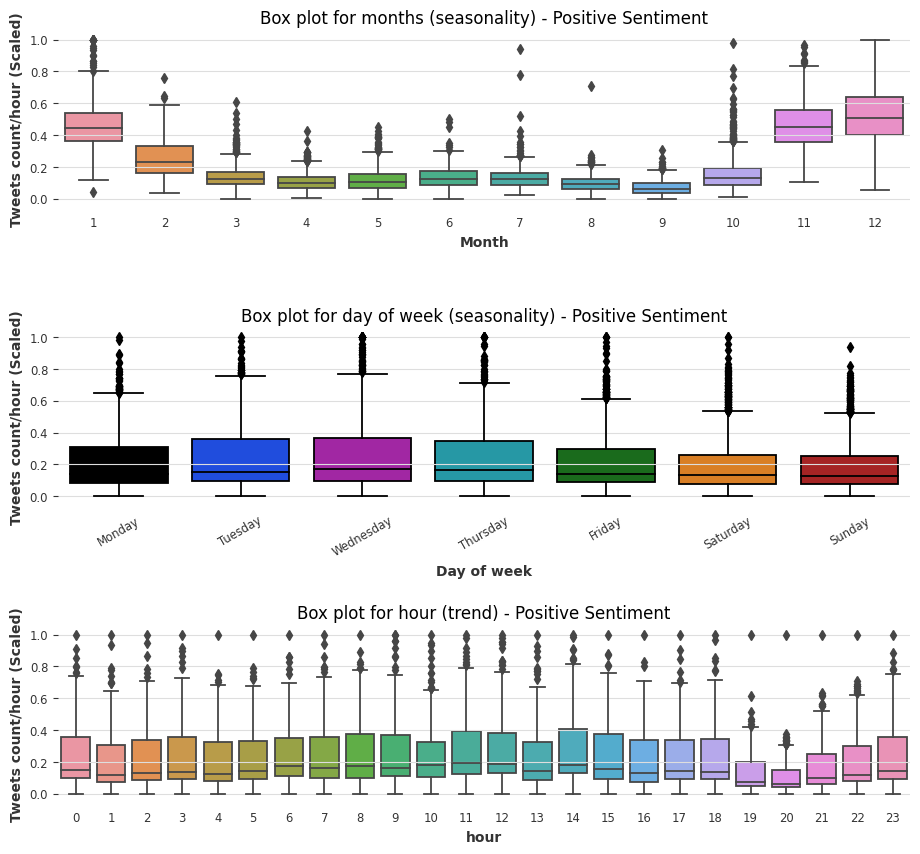

In [11]:
# visualize 

s_id = '1'
df = dataset_scaled_EDA[dataset_scaled_EDA.sentiment == s_id]
sentiment = 'Negative' if s_id == '0' else 'Positive'

fig, ax = plt.subplots(3,1, figsize=(11,10))
sns.boxplot(x='month', y='hour_scaled', data=df, ax=ax[0]) \
    .set( xlabel='Month', 
        ylabel='Tweets count/hour (Scaled)'
        )
ax[0].set_title(f'Box plot for months (seasonality) - {sentiment} Sentiment')


sns.boxplot(x='day_of_week', y='hour_scaled', data=df, ax=ax[1]) \
    .set(xlabel='Day of week', 
        ylabel='Tweets count/hour (Scaled)'
        )
ax[1].set_title(f'Box plot for day of week (seasonality) - {sentiment} Sentiment')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=30)

sns.boxplot(x='hour', y='hour_scaled', data=df, ax=ax[2]) \
    .set(xlabel='hour', 
        ylabel='Tweets count/hour (Scaled)'
        )
ax[2].set_title(f'Box plot for hour (trend) - {sentiment} Sentiment')

plt.subplots_adjust(hspace=0.7) 
plt.show()

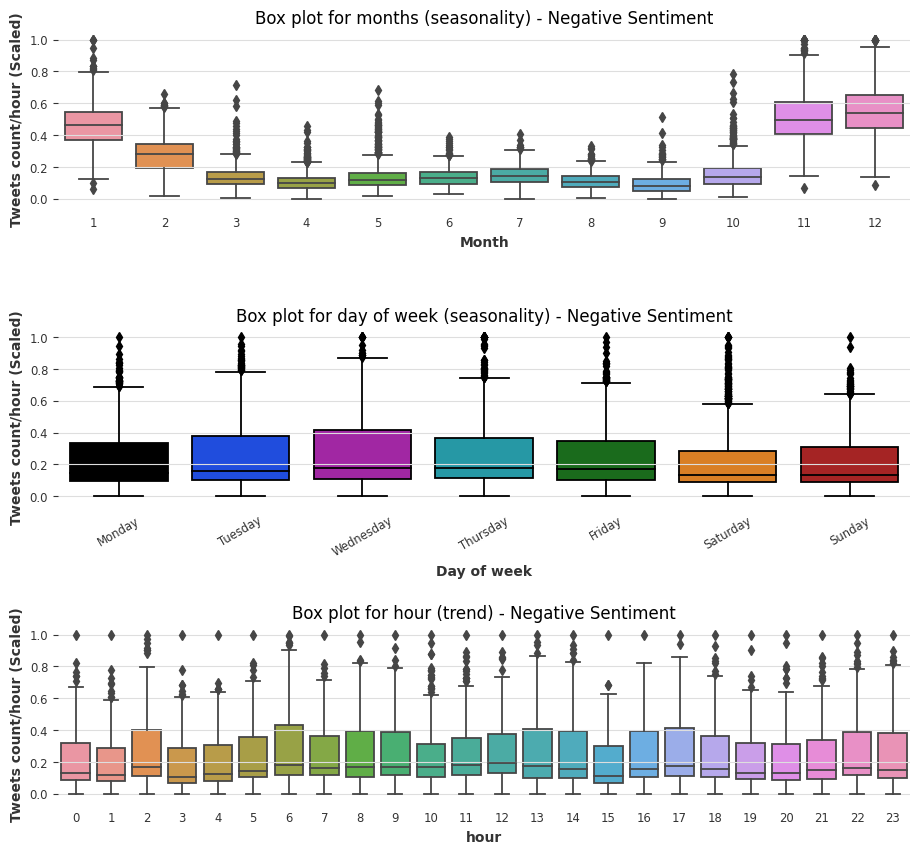

In [12]:
# visualize 

s_id = '0'
df = dataset_scaled_EDA[dataset_scaled_EDA.sentiment == s_id]
sentiment = 'Negative' if s_id == '0' else 'Positive'

fig, ax = plt.subplots(3,1, figsize=(11,10))
sns.boxplot(x='month', y='hour_scaled', data=df, ax=ax[0]) \
    .set( xlabel='Month', 
        ylabel='Tweets count/hour (Scaled)'
        )
ax[0].set_title(f'Box plot for months (seasonality) - {sentiment} Sentiment')


sns.boxplot(x='day_of_week', y='hour_scaled', data=df, ax=ax[1]) \
    .set(xlabel='Day of week', 
        ylabel='Tweets count/hour (Scaled)'
        )
ax[1].set_title(f'Box plot for day of week (seasonality) - {sentiment} Sentiment')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=30)

sns.boxplot(x='hour', y='hour_scaled', data=df, ax=ax[2]) \
    .set(xlabel='hour', 
        ylabel='Tweets count/hour (Scaled)'
        )
ax[2].set_title(f'Box plot for hour (trend) - {sentiment} Sentiment')

plt.subplots_adjust(hspace=0.7) 
plt.show()

In [45]:
def set_df_sent(df_send, sent=False, target_col='hourly_count', rename_target_col='target', new_index=False,
                split_col='datetime', split_date='2022-10-01', freq_timestamp='H', x_col=[]):

    df = df_send.copy()
    
    n_row = len(df)

    if not sent == False:
        sent_desc = 'Positive' if sent == '1' else 'Negative'
        print(f'Dataframe Sentiment: {sent_desc}')

        # Remove Sentiment:
        df = df[df.sentiment == sent]
        n_row = len(df)

    print(f'Total Number of rows: {n_row}')
    cols = x_col

    if not new_index == False:
        # Apply Time as index
        df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S')
        df = df.set_index('datetime')

        # verifying if there are missing time (hour)
        df = df.asfreq(freq_timestamp)
        print(f"NA's rows Number: {np.abs(n_row - len(df))}")
        df = df.fillna(0)

    df = df.rename(columns={target_col: rename_target_col})
    cols.append(rename_target_col)
    
    if new_index == False:
        cols.append(split_col)

    df = df[cols]

    # Splitting dataframes into train-test
    if new_index == False:
        df_train = df[pd.to_datetime(df[split_col], format='%Y-%m-%d %H:%M:%S') < pd.to_datetime(split_date, format='%Y-%m-%d')]
        print(f"Train dates : {df_train[split_col].min()} --- {df_train[split_col].max()}  (n={len(df_train)} -> {len(df_train)/len(df):.2%})")

        df_test = df[pd.to_datetime(df[split_col], format='%Y-%m-%d %H:%M:%S') >= pd.to_datetime(split_date, format='%Y-%m-%d')]
        print(f"Test dates  : {df_test[split_col].min()} --- {df_test[split_col].max()}  (n={len(df_test)} -> {len(df_test)/len(df):.2%})")

    else:
        df_train = df.loc[df.index < pd.to_datetime(split_date, format='%Y-%m-%d')]
        print(f"Train dates : {df_train.index.min()} --- {df_train.index.max()}  (n={len(df_train)} -> {len(df_train)/len(df):.2%})")

        df_test = df.loc[df.index >= pd.to_datetime(split_date, format='%Y-%m-%d')]
        print(f"Test dates  : {df_test.index.min()} --- {df_test.index.max()}  (n={len(df_test)} -> {len(df_test)/len(df):.2%})")


    fig, ax = plt.subplots(figsize=(11, 4))
    df_train[rename_target_col].plot(ax=ax, label='train', color='blue')
    df_test[rename_target_col].plot(ax=ax, label='test', color='black')
    ax.legend();
    ax.set_title(f"Train-Test dataframes {sent_desc} Sentiment")

    return df, df_train, df_test


In [43]:
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

def kpss_test(serie):   
    print('Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test', '\n')
    
    statistic, p_value, n_lags, critical_values = kpss(serie)
    
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    
    print(f'Result: {"Failed to Reject Ho - Time Series is " if p_value < 0.05 else "Reject Ho - Time Series is Non-"}stationary')
    #print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

def adf_test(serie):
    print('Augmented Dickey-Fuller (ADF) Test', '\n')
    
    result_adfuller = adfuller(serie)
    adf_statistic = result_adfuller[0]
    p_value = result_adfuller[1]
    critical_values = result_adfuller[4]

    print(f'ADF Statistic: {adf_statistic}')
    print(f'p-value: {p_value}')
    print('Critical Values:')
    for key, value in critical_values.items():
        print(f'   {key}: {value}')
        
    print(f'Result: {"Reject Ho - Time Series is " if p_value < 0.05 else "Failed to Reject Ho - Time Series is Non-"}stationary')


Dataframe Sentiment: Positive
Total Number of rows: 8752
NA's rows Number: 8
Train dates : 2021-11-01 00:00:00 --- 2022-09-30 23:00:00  (n=8016 -> 91.51%)
Test dates  : 2022-10-01 00:00:00 --- 2022-10-31 23:00:00  (n=744 -> 8.49%)


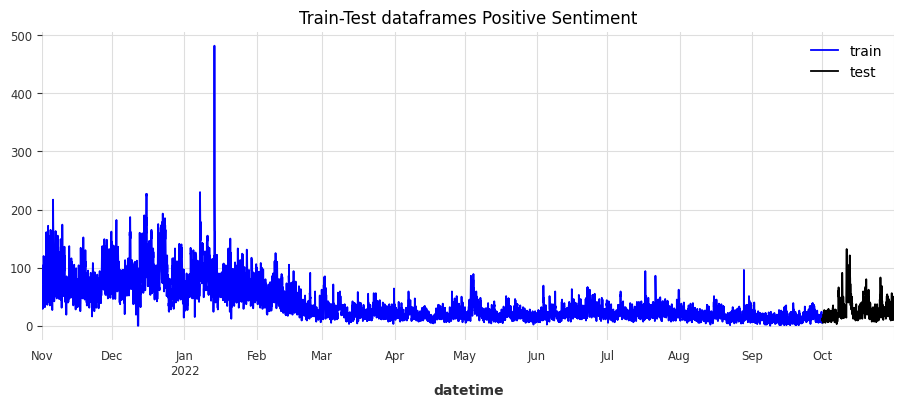

In [27]:
tweets_hour_pos, tweets_hour_pos_train, tweets_hour_pos_test = set_df_sent(tweets_hour_pd, rename_target_col = 'target',
                                                                          sent = '1', new_index="datetime")

Dataframe Sentiment: Negative
Total Number of rows: 8752
NA's rows Number: 8
Train dates : 2021-11-01 00:00:00 --- 2022-09-30 23:00:00  (n=8016 -> 91.51%)
Test dates  : 2022-10-01 00:00:00 --- 2022-10-31 23:00:00  (n=744 -> 8.49%)


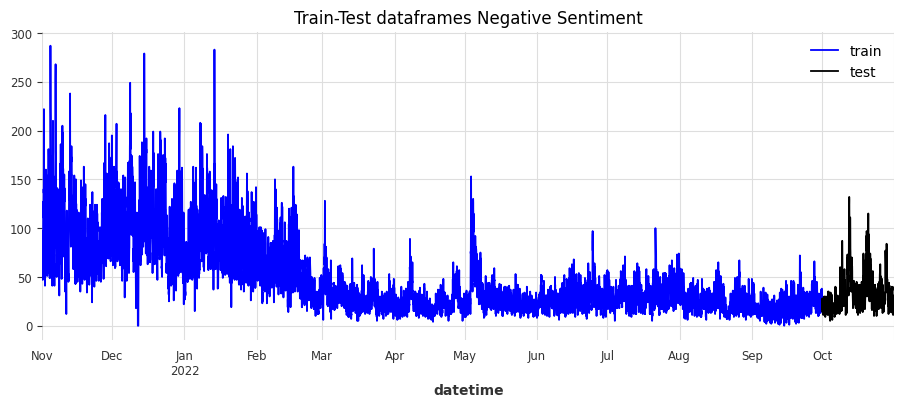

In [67]:
tweets_hour_neg, tweets_hour_neg_train, tweets_hour_neg_test = set_df_sent(tweets_hour_pd, 
                                                                           rename_target_col = 'target',
                                                                           sent = '0', 
                                                                           new_index="datetime")

Augmented Dickey-Fuller (ADF) Test 

ADF Statistic: -4.4616274676481185
p-value: 0.00023053457656712703
Critical Values:
   1%: -3.4310994528274854
   5%: -2.861871208252867
   10%: -2.5669462971858117
Result: Reject Ho - Time Series is stationary


Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test 

KPSS Statistic: 10.26961489735929
p-value: 0.01
num lags: 54
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: Failed to Reject Ho - Time Series is stationary

 	 Graphics 



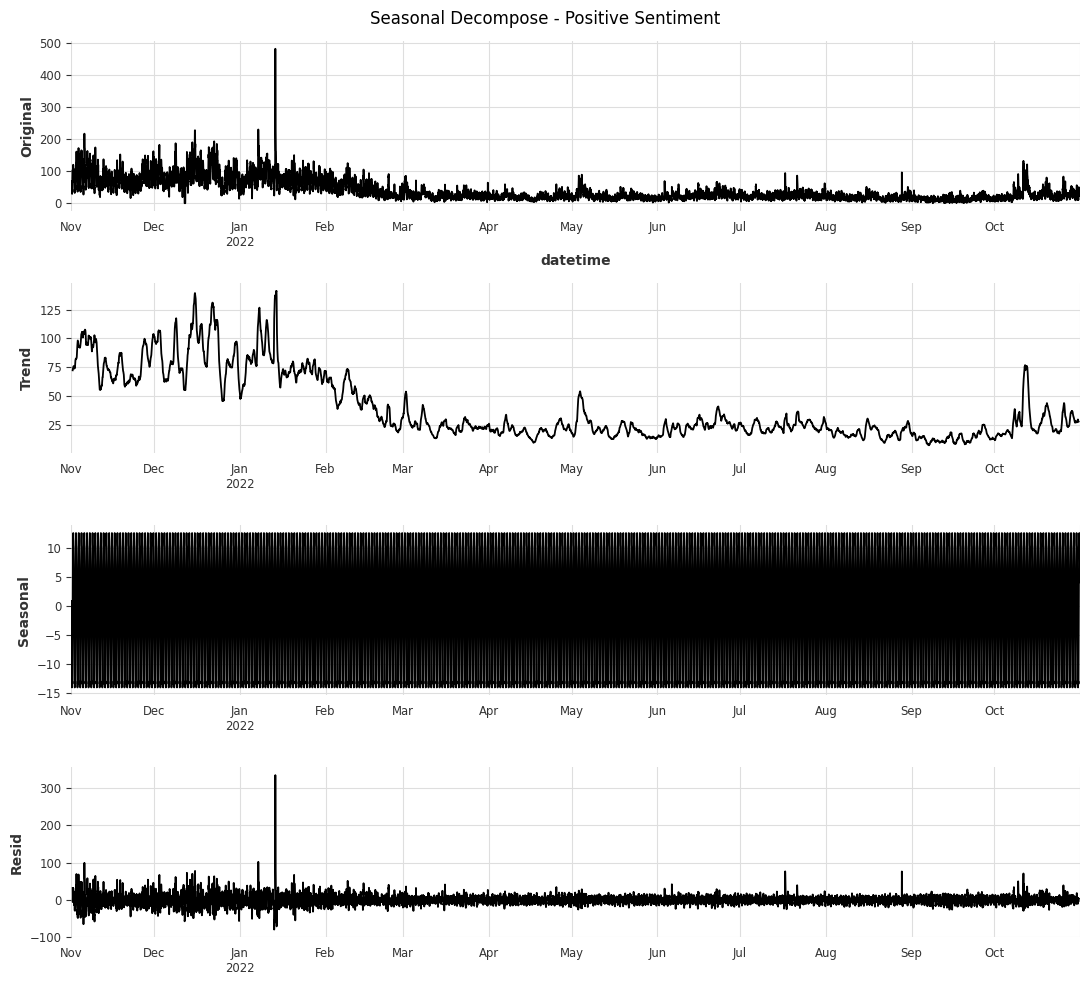

In [32]:
serie = tweets_hour_pos['target']
index = pd.date_range(start=tweets_hour_pos.index.min(), end=tweets_hour_pos.index.max(), freq='H')
serie = pd.Series(serie.values, index=index)

adf_test(serie)
print('\n')
kpss_test(serie)
    
print('\n', '\t Graphics', '\n')
    
result_decompose = seasonal_decompose(serie, model='additive')

# Plotar as componentes
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(11, 10))
tweets_hour_pos['target'].plot(ax=ax1)
ax1.set_ylabel('Original')
result_decompose.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')
result_decompose.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')
result_decompose.resid.plot(ax=ax4)
ax4.set_ylabel('Resid')

fig.suptitle('Seasonal Decompose - Positive Sentiment')
plt.tight_layout()
plt.show()


Augmented Dickey-Fuller (ADF) Test 

ADF Statistic: -4.768720495188122
p-value: 6.239595479734889e-05
Critical Values:
   1%: -3.4310994528274854
   5%: -2.861871208252867
   10%: -2.5669462971858117
Result: Reject Ho - Time Series is stationary


Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test 

KPSS Statistic: 10.45159715687928
p-value: 0.01
num lags: 54
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: Failed to Reject Ho - Time Series is stationary

 	 Graphics 



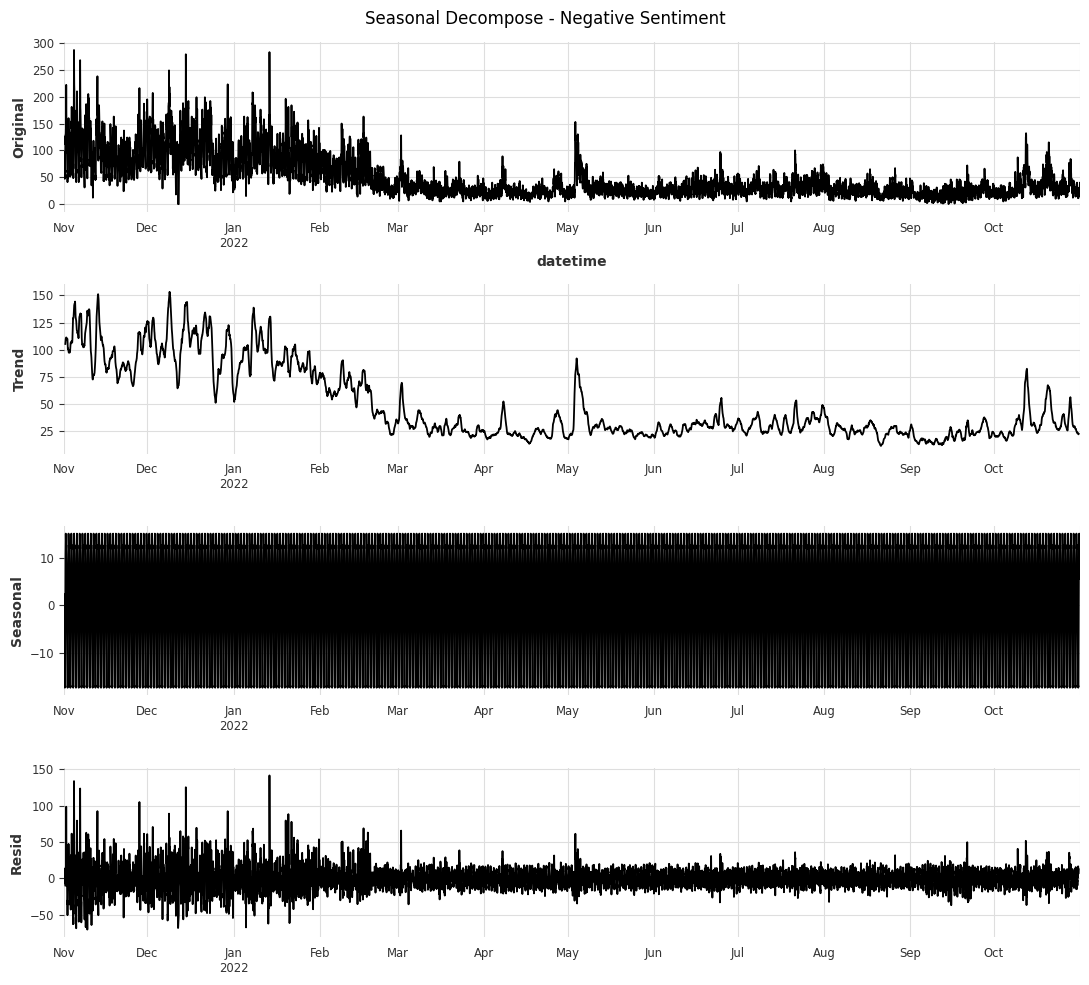

In [69]:
serie = tweets_hour_neg['target']
index = pd.date_range(start=tweets_hour_neg.index.min(), end=tweets_hour_neg.index.max(), freq='H')
serie = pd.Series(serie.values, index=index)

adf_test(serie)
print('\n')
kpss_test(serie)
    
print('\n', '\t Graphics', '\n')
    
result_decompose = seasonal_decompose(serie, model='additive')

# Plotar as componentes
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(11, 10))
tweets_hour_neg['target'].plot(ax=ax1)
ax1.set_ylabel('Original')
result_decompose.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')
result_decompose.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')
result_decompose.resid.plot(ax=ax4)
ax4.set_ylabel('Resid')

fig.suptitle('Seasonal Decompose - Negative Sentiment')
plt.tight_layout()
plt.show()


## Training and testing

### Darts Models

#### Getting Data

In [86]:
dataset_ts = tweets_hour_pd.copy()
dataset_ts = TimeSeries.from_group_dataframe(df=dataset_ts,
                                             group_cols= 'sentiment',
                                             time_col='datetime',
                                             value_cols='hourly_count',
                                             freq= 'H',
                                            )

In [87]:
first_test_date = pd.Timestamp('2022-10-01')
train_dataset_ts, test_dataset_ts = [], []

for single_ts in tqdm(dataset_ts):
    # split into train and test tests
    single_train_ts, single_test_ts = single_ts.split_before(first_test_date)
    train_dataset_ts.append(single_train_ts)
    test_dataset_ts.append(single_test_ts)

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 155.01it/s]


In [88]:
forecast_horizons = len(test_dataset_ts[0])

def _backtests_local_estimator(_estimator, _ts_set, _split_date, _horizons, _single_forecast):
    model = _estimator
    if _single_forecast:
        model.fit(_ts_set.split_before(_split_date)[0])
        backtests_single_ts = model.predict(_horizons)
    
    else:
        backtests_single_ts = model.historical_forecasts(series=_ts_set, 
                                                         start=_split_date - np.timedelta64(_horizons-1, 'D'), 
                                                         verbose=False, 
                                                         overlap_end=False,
                                                         last_points_only=True, 
                                                         forecast_horizon=_horizons,
                                                         retrain=True)
    
    return backtests_single_ts

def backtests_multiple_local_estimators(estimator, multiple_ts_sets=dataset_ts, split_date=first_test_date, horizons=forecast_horizons, single_forecast=True):
    backtests_multiple_ts = Parallel(n_jobs=-1,
                                     verbose=5, 
                                     backend = 'multiprocessing',
                                     pre_dispatch='1.5*n_jobs')(
            delayed(_backtests_local_estimator)(
                _estimator=estimator,
                _ts_set=single_ts_set,
                _split_date=split_date,
                _horizons=horizons,
                _single_forecast=single_forecast
            )
        for single_ts_set in multiple_ts_sets
    )
    
    return backtests_multiple_ts


def darts_kpi(prediction_series, test_series=test_dataset_ts):
    mape_ = np.round(np.mean(mape(actual_series=test_series, 
                                 pred_series=prediction_series, n_jobs=-1)),
                    2)
    print(f' MAPE: {mape_}')
    
    rmse_ = np.round(np.mean(coefficient_of_variation(actual_series=test_series, 
                                 pred_series=prediction_series, n_jobs=-1)),
                    2)
    print(f' RMSE: {rmse_}')
    
    mae_ = np.round(np.mean(mae(actual_series=test_series, 
                                 pred_series=prediction_series, n_jobs=-1)),
                    2)
    print(f' MAE: {mae_}')

#### NaiveSeasonal

[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished


 MAPE: 51.59
 RMSE: 74.87
 MAE: 16.52


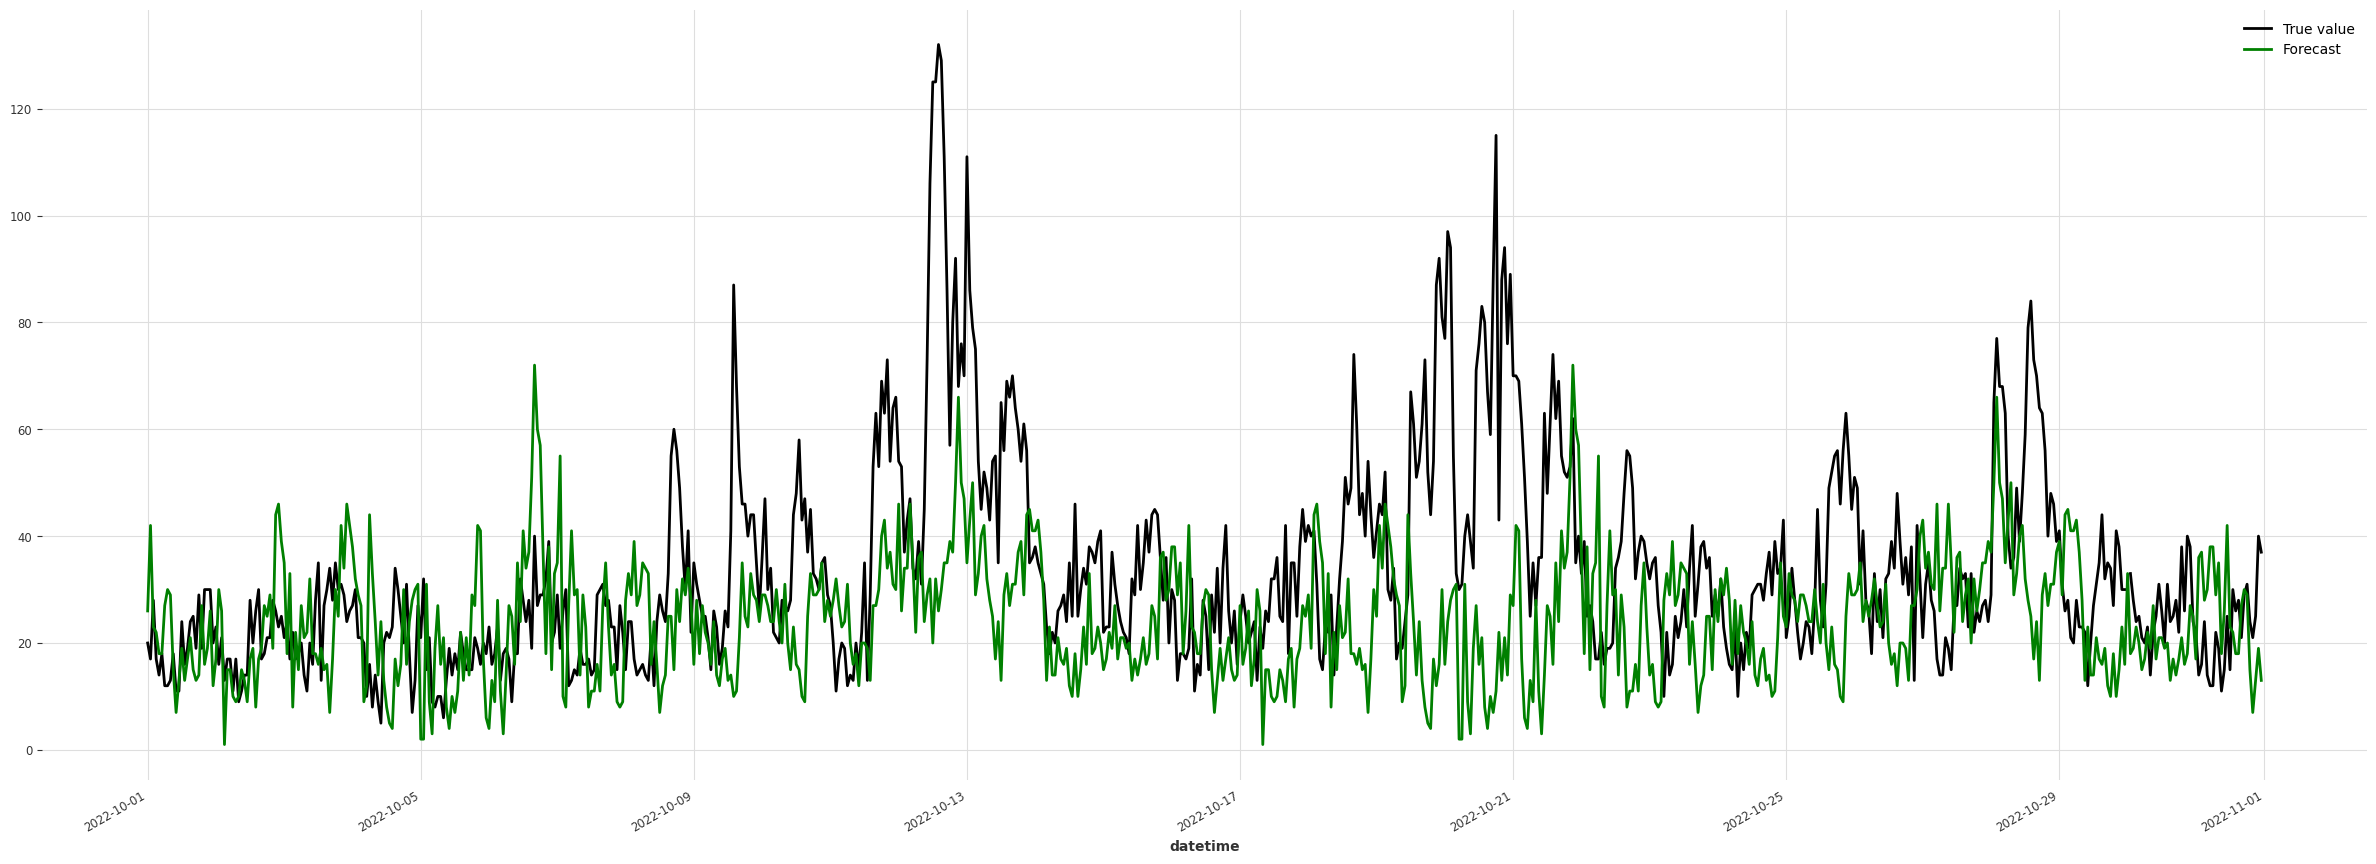

In [ ]:
backtests_baseline_model = backtests_multiple_local_estimators(estimator=NaiveSeasonal(K=365))
darts_kpi(backtests_baseline_model)

fig, ax = plt.subplots(figsize=(30, 10))
test_dataset_ts[0].plot(label='True value', color='black')
backtests_baseline_model[0].plot(label='Forecast', color='green')
plt.show()

#### AUTOarima

[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    7.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    7.7s finished


 MAPE: 58.49
 RMSE: 89.59
 MAE: 20.26


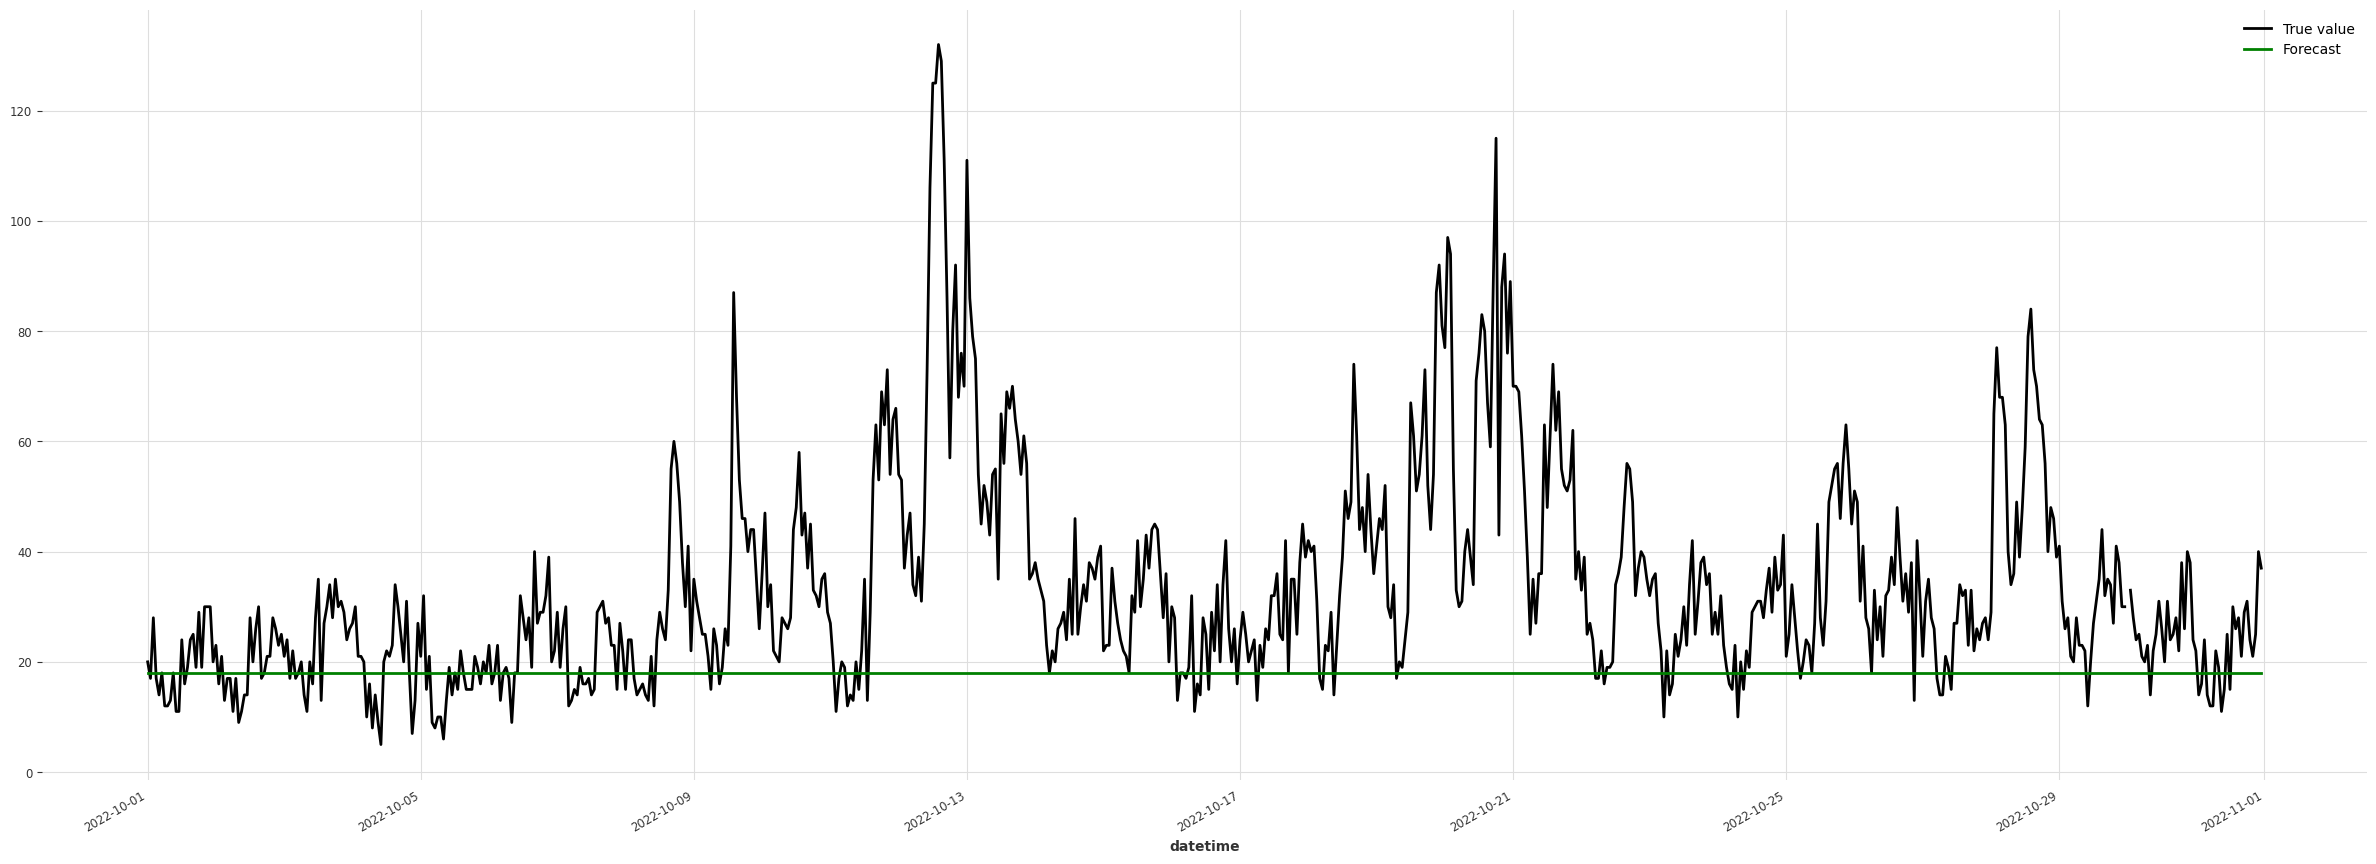

In [24]:
backtests_AUTOarima = backtests_multiple_local_estimators(estimator=StatsForecastAutoARIMA())
darts_kpi(backtests_AUTOarima)

fig, ax = plt.subplots(figsize=(30, 10))
test_dataset_ts[0].plot(label='True value', color='black')
backtests_AUTOarima[0].plot(label='Forecast', color='green')
plt.show()

#### prophet

[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.4s finished


 MAPE: 69.11
 RMSE: 83.77
 MAE: 20.18


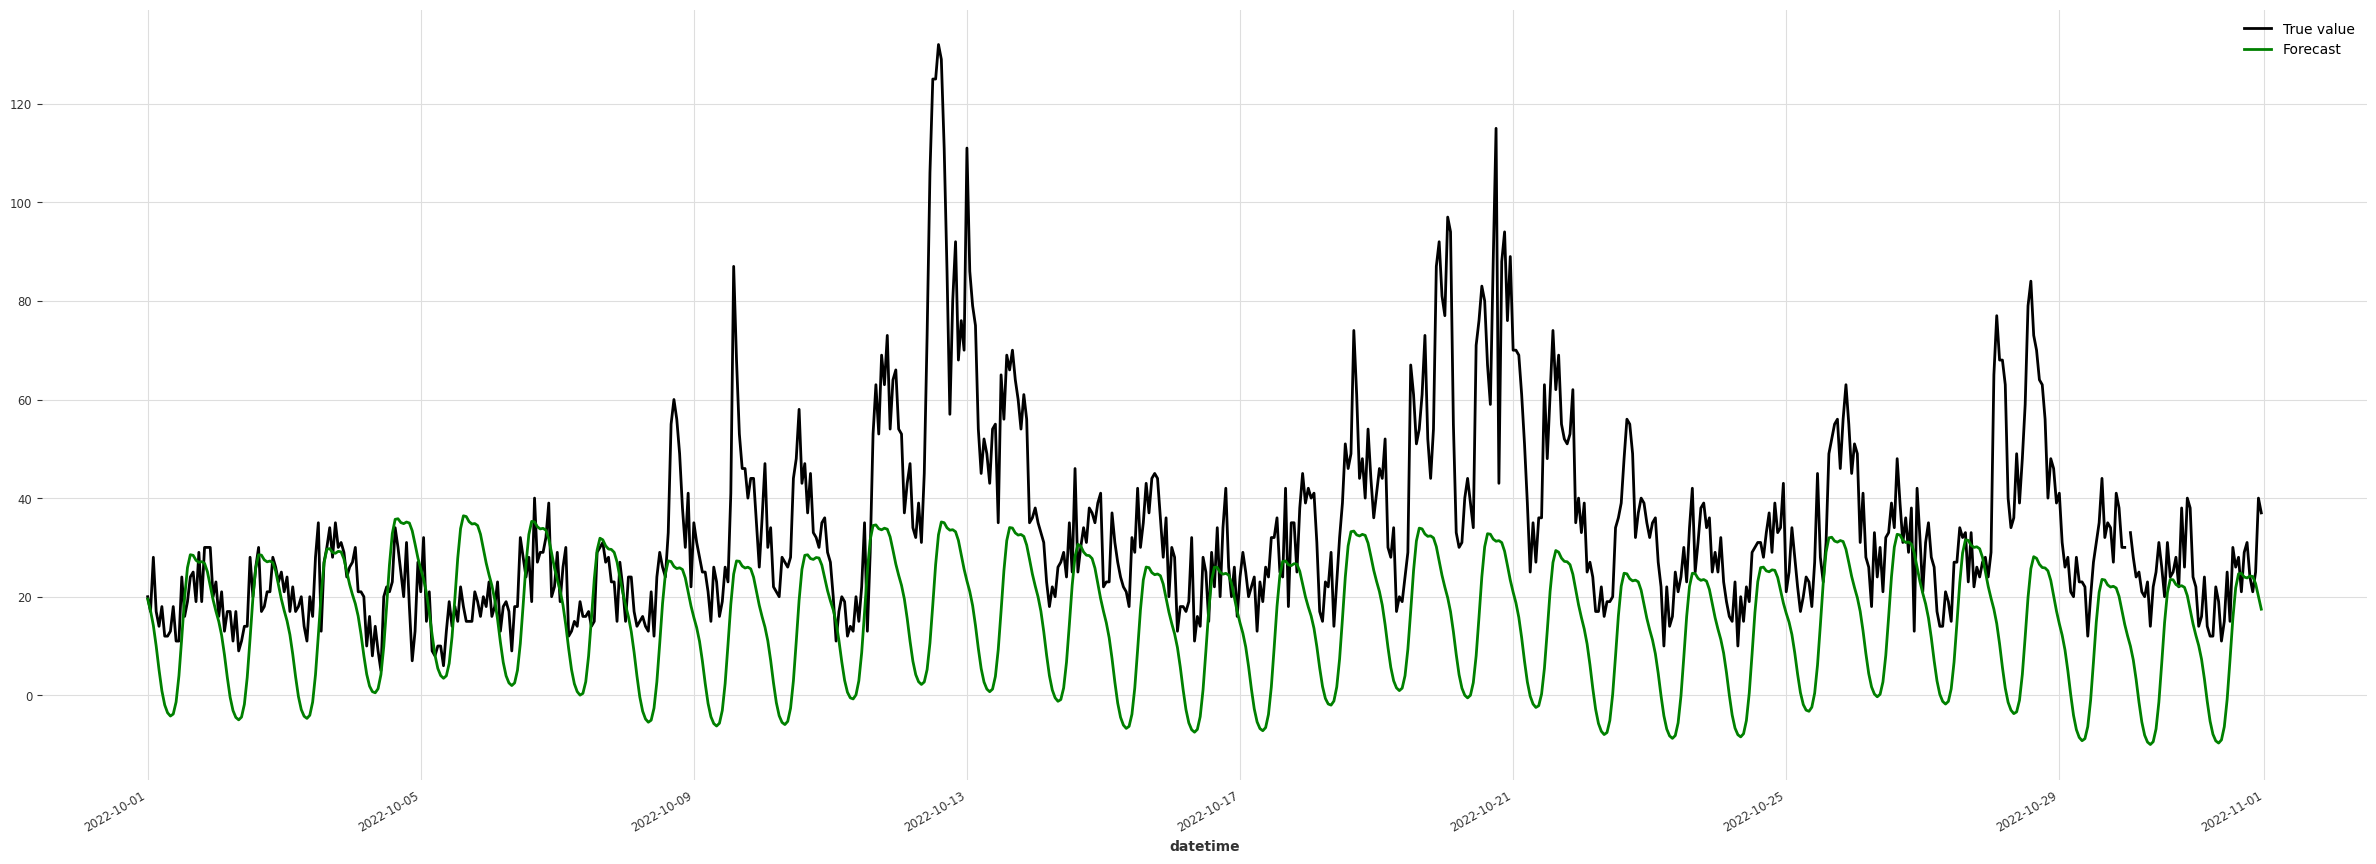

In [17]:
backtests_prophet = backtests_multiple_local_estimators(estimator=Prophet())
darts_kpi(backtests_prophet)

fig, ax = plt.subplots(figsize=(30, 10))
test_dataset_ts[0].plot(label='True value', color='black')
backtests_prophet[0].plot(label='Forecast', color='green')
plt.show()

#### Croston

[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.4s finished


 MAPE: 44.13
 RMSE: 73.11
 MAE: 15.0


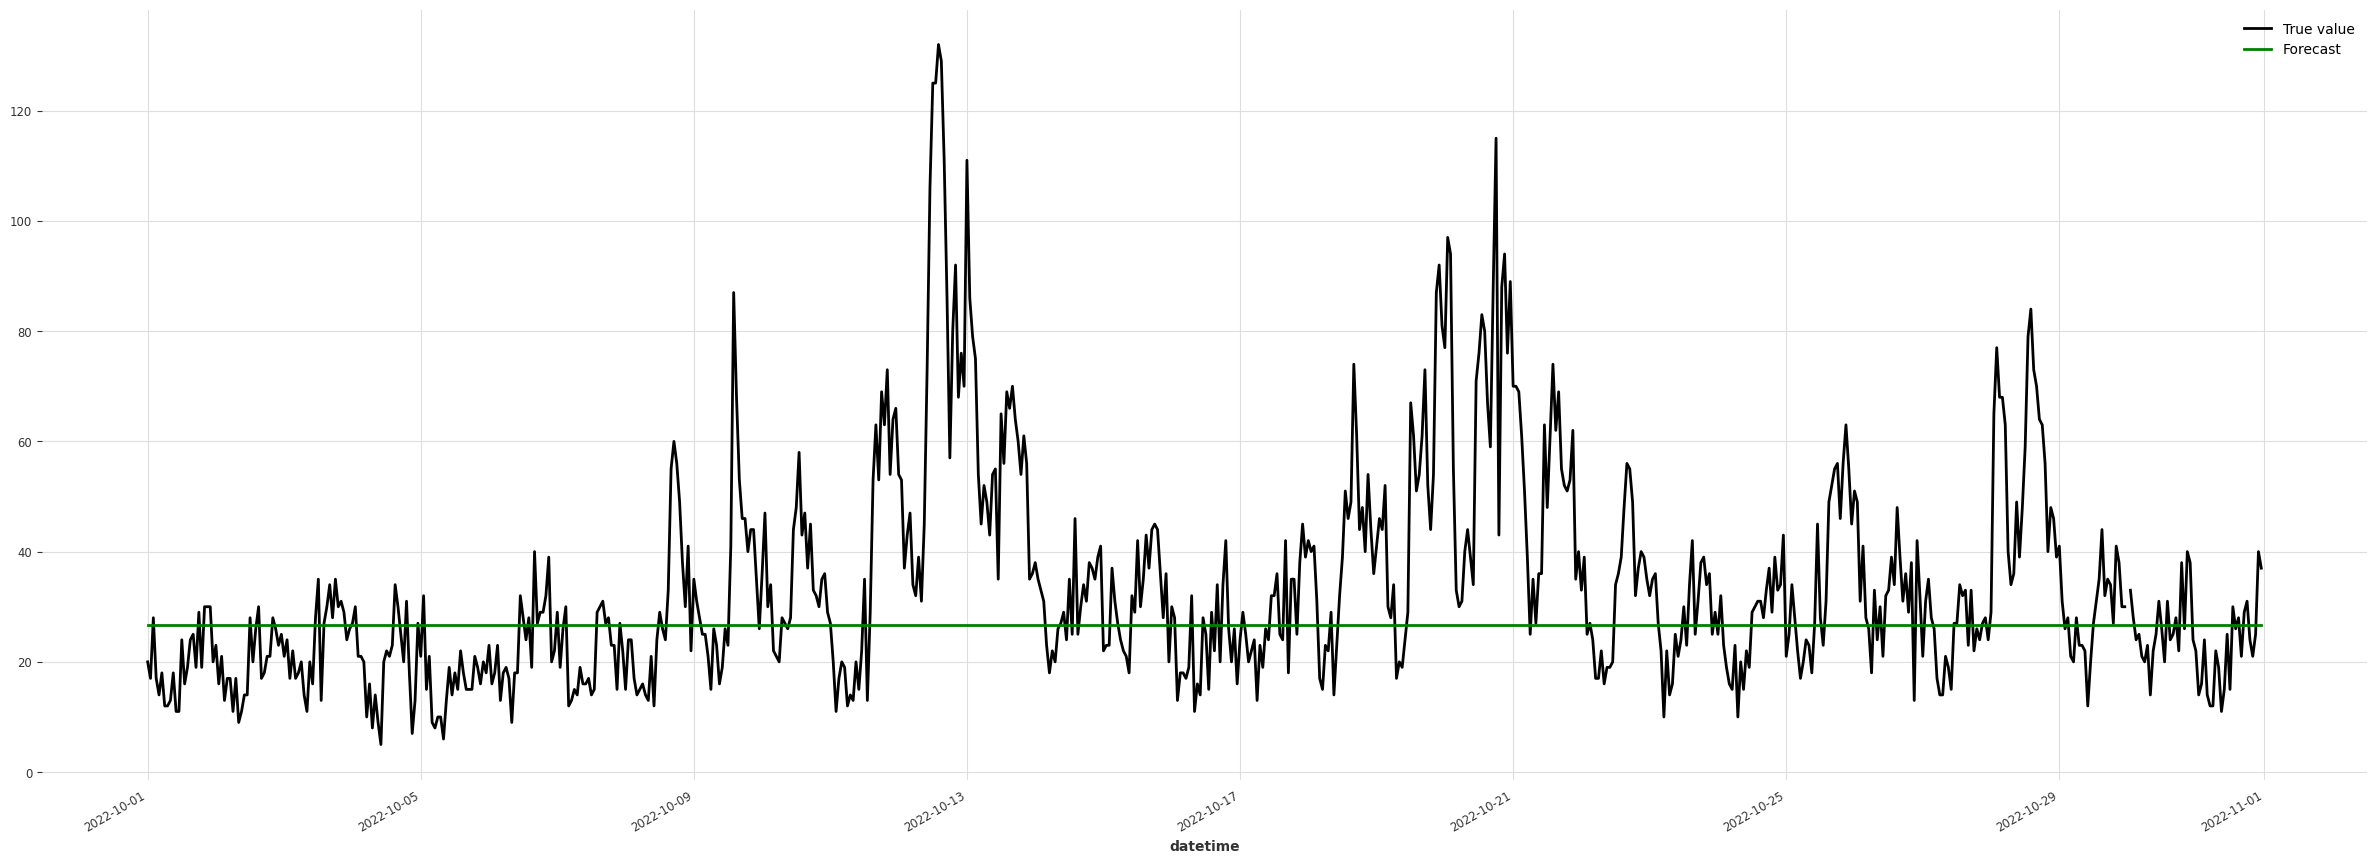

In [89]:
from darts.models import Croston

backtests_croston = backtests_multiple_local_estimators(estimator=Croston())
darts_kpi(backtests_croston)

fig, ax = plt.subplots(figsize=(30, 10))
test_dataset_ts[0].plot(label='True value', color='black')
backtests_croston[0].plot(label='Forecast', color='green')
plt.show()

### XGBoost

In [48]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold


In [49]:
tweets_hour_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17504 entries, 0 to 17503
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          17504 non-null  int32  
 1   month         17504 non-null  int32  
 2   day           17504 non-null  int32  
 3   hour          17504 non-null  int32  
 4   sentiment     17504 non-null  object 
 5   hourly_score  17504 non-null  float64
 6   hourly_count  17504 non-null  int64  
 7   datetime      17504 non-null  object 
dtypes: float64(1), int32(4), int64(1), object(2)
memory usage: 820.6+ KB


In [50]:
df = tweets_hour_pd.copy()

df = df[['year', 'month', 'day', 'hour', 'sentiment','hourly_count']]

n_row = len(df)
print(f'Total Number of rows: {n_row}')

#verifying if there are na's value   
df = df.dropna()
print(f"NA's rows Number: {np.abs(n_row - len(df))}")

X, y = df[['year', 'month', 'day', 'hour', 'sentiment']].values, df[['hourly_count']].values



Total Number of rows: 17504
NA's rows Number: 0


In [51]:
#Splitting dataframes into train-test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123) 
print(f"Train n={len(X_train)} -> {len(X_train)/len(df):.2%})")
print(f"Test n={len(X_test)} -> {len(X_test)/len(df):.2%})")

Train n=14003 -> 80.00%)
Test n=3501 -> 20.00%)


In [52]:
reg_mod = xgb.XGBRegressor(objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.10,
    subsample=0.5,
    colsample_bytree=1, 
    max_depth=5,
)
reg_mod.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [53]:
reg_mod.fit(X_train,y_train)

predictions = reg_mod.predict(X_test)

In [54]:
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("RMSE: %f" % (rmse))

from sklearn.metrics import r2_score
r2 = np.sqrt(r2_score(y_test, predictions))
print("R_Squared Score : %f" % (r2))

RMSE: 11.296685
R_Squared Score : 0.952342


In [63]:
def df_future(df_trained, day_future, model):
    
    df_trained['datetime'] = pd.to_datetime(df_trained['datetime'])
    start = df_trained.datetime.max()
    
    date = pd.date_range(start=start, end=start + pd.DateOffset(days=day_future), freq='H')

    df = pd.DataFrame({'date': date})
    df['year'] = pd.DatetimeIndex(df['date']).year
    df['month'] = pd.DatetimeIndex(df['date']).month
    df['day'] = pd.DatetimeIndex(df['date']).day
    df['hour'] = pd.DatetimeIndex(df['date']).hour
    
    df1 = df.copy()
    df['sentiment'] = '0' 
    df1['sentiment'] = '1' 
    df = pd.concat([df, df1]).sort_values('date').reset_index(drop=True)
    df1 = df.drop('date', axis = 1)
    
    pred = model.predict(df1.values)
    df['prediction'] = pred.tolist()
    
    df = df.set_index('date')
    df_trained = df_trained.set_index('datetime')
    
    
    # Plotar as componentes
    fig1, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(11, 10))
    df_trained['hourly_count'].plot(ax=ax1, label='Original', color='black')
    df['prediction'].plot(ax=ax1, label='Prediction', color='green') 
    ax1.set_ylabel('Total')

    df_trained[df_trained.sentiment == '1']['hourly_count'].plot(ax=ax2, label='Original', color='black')
    df[df.sentiment == '1']['prediction'].plot(ax=ax2, label='Prediction', color='green') 
    ax2.set_ylabel('Positive Sentiment')    
    
    df_trained[df_trained.sentiment == '0']['hourly_count'].plot(ax=ax3, label='Original', color='black')
    df[df.sentiment == '0']['prediction'].plot(ax=ax3, label='Prediction', color='green') 
    ax3.set_ylabel('Negative Sentiment')   
    
    fig1.suptitle(f'Forecast - {day_future} days')

    plt.tight_layout()
    plt.show()
    
    return df

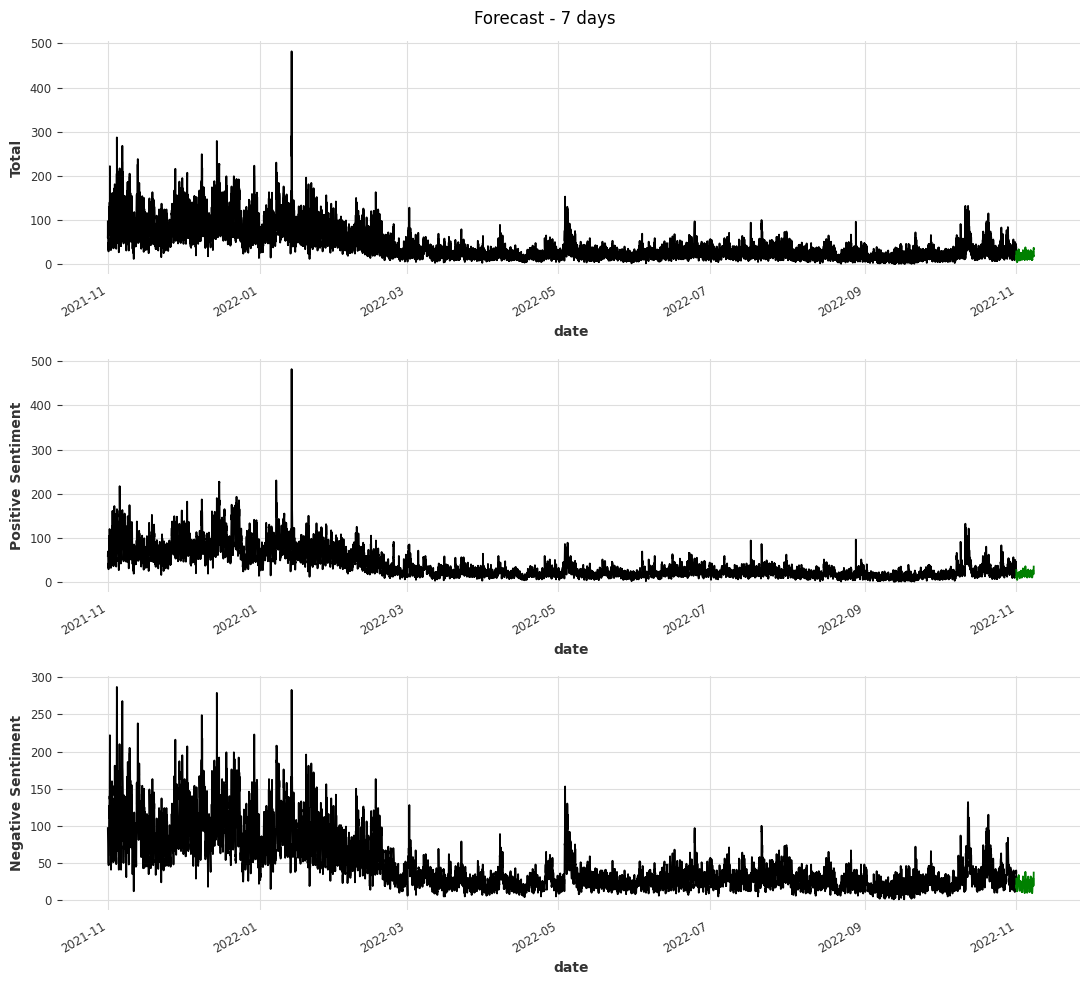

In [64]:
future_7d = df_future(df_trained = tweets_hour_pd, 
                      day_future = 7,
                      model = reg_mod)


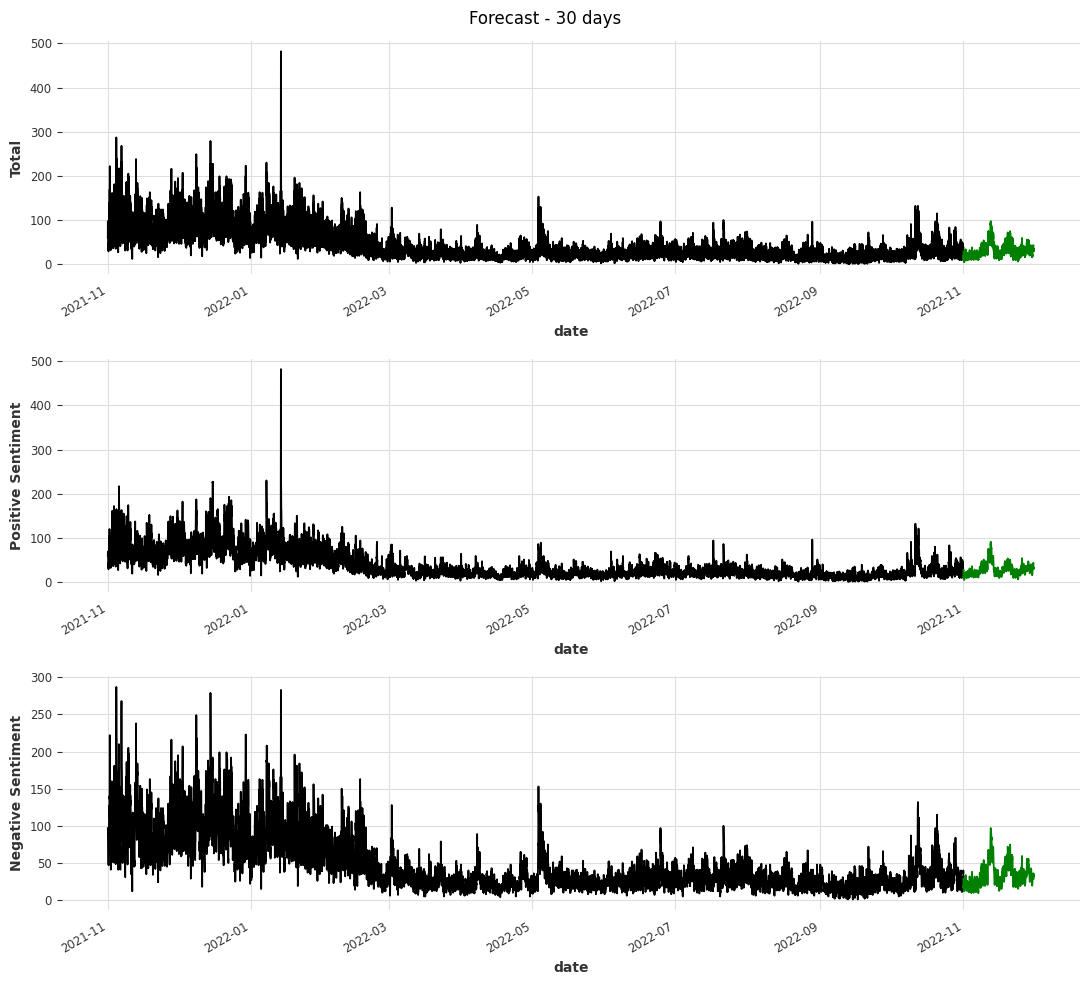

In [65]:
future_30d = df_future(df_trained = tweets_hour_pd, 
                      day_future = 30,
                      model = reg_mod)


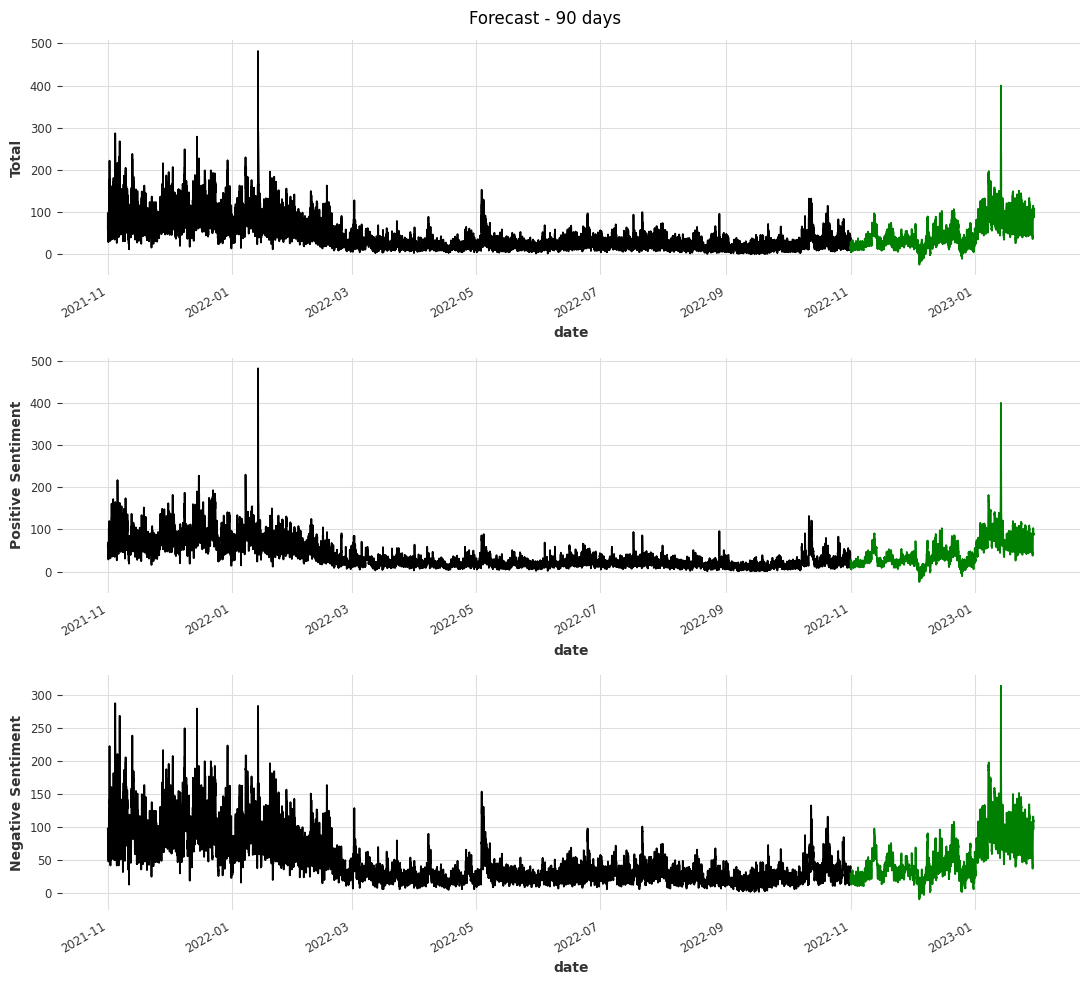

In [66]:
future_90d = df_future(df_trained = tweets_hour_pd, 
                      day_future = 90,
                      model = reg_mod)
